In [ ]:
import sys
import os
import io
import boto3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from dotenv import load_dotenv

sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

load_dotenv('../.env')

def load_training_data():
    """Fetches all labeled parquet files from S3 and combines them."""
    bucket = os.getenv('S3_BUCKET_NAME')
    s3 = boto3.client(
        's3',
        aws_access_key_id=os.getenv('AWS_ACCESS_KEY_ID'),
        aws_secret_access_key=os.getenv('AWS_SECRET_ACCESS_KEY'),
        region_name='us-east-1'
    )
    
    print("Fetching labeled data from S3...")
    response = s3.list_objects_v2(Bucket=bucket, Prefix='training_data/')
    
    if 'Contents' not in response:
        print("No training data found.")
        return pd.DataFrame()
        
    dfs = []
    for obj in response['Contents']:
        if obj['Key'].endswith('.parquet'):
            data = s3.get_object(Bucket=bucket, Key=obj['Key'])['Body'].read()
            dfs.append(pd.read_parquet(io.BytesIO(data)))
            
    df = pd.concat(dfs, ignore_index=True)
    print(f"Successfully loaded {len(df)} labeled trades.")
    return df

df = load_training_data()
df.head()

Fetching labeled data from S3...
Successfully loaded 16042 labeled trades.


,company_name,ticker,contract_name,expiration_date,last_trade_date,stock_price,strike,premium,bid,ask,...,dividend_yield,snapshot_date,final_price,assigned,realized_value,realized_return_pct,target_profitable,days_held,realized_annual_return,target_high_quality
0,Shell PLC,SHEL,SHEL250417C00062500,2025-04-17,2025-04-07 19:10:05,59.760,62.5,2.15,1.10,1.25,...,4.47,2025-04-08,63.113800,True,64.650000,0.081827,True,9,3.318552,True
1,Enterprise Products Partners L.,EPD,EPD250417C00029000,2025-04-17,2025-04-08 18:42:35,28.950,29.0,1.03,1.05,1.11,...,6.94,2025-04-08,28.961407,False,29.991407,0.035973,True,9,1.458889,True
2,Enterprise Products Partners L.,EPD,EPD250417C00029500,2025-04-17,2025-04-08 16:22:00,28.950,29.5,0.95,0.77,0.83,...,6.94,2025-04-08,28.961407,False,29.911407,0.033209,True,9,1.346818,True
3,iShares Core S&P Total U.S. Sto,ITOT,ITOT250417C00121000,2025-04-17,2025-04-02 19:10:14,107.950,121.0,3.40,0.00,0.35,...,1.33,2025-04-08,113.768669,False,117.168669,0.085398,True,9,3.463346,True
4,Carnival Corporation,CCL,CCL250411C00026500,2025-04-11,2025-04-04 13:41:57,16.515,26.5,0.50,0.00,0.00,...,0.00,2025-04-08,17.639999,False,18.139999,0.098395,True,3,11.971436,True


In [ ]:
def engineer_features(data):
    """Creates derived ratios and metrics for ML analysis."""
    d = data.copy()
    
    # 1. Distance to Strike (The Safety Cushion)
    # Positive means out-of-the-money (safer for covered calls)
    d['distance_to_strike_pct'] = (d['strike'] - d['stock_price']) / d['stock_price']
    
    # 2. Premium Yield (Reward)
    d['premium_yield'] = d['premium'] / d['stock_price']
    
    # 3. Liquidity Risk
    # High volume relative to open interest can signal a sudden breakout
    d['vol_oi_ratio'] = d['volume'] / (d['open_interest'] + 1)
    
    # 4. Days to Expiry (DTE)
    d['dte'] = (d['expiration_date'] - d['snapshot_date']).dt.days
    d['dte'] = d['dte'].replace(0, 1) # Prevent division by zero
    
    # 5. Annualized Yield
    d['annualized_yield'] = d['premium_yield'] * (365 / d['dte'])
    
    # 6. Risk-Adjusted Return
    # How much yield are we getting per unit of implied volatility?
    d['yield_to_iv_ratio'] = d['annualized_yield'] / (d['implied_volatility'] + 0.001)
    
    return d

df_ml = engineer_features(df)
print("Features engineered successfully.")

Features engineered successfully.


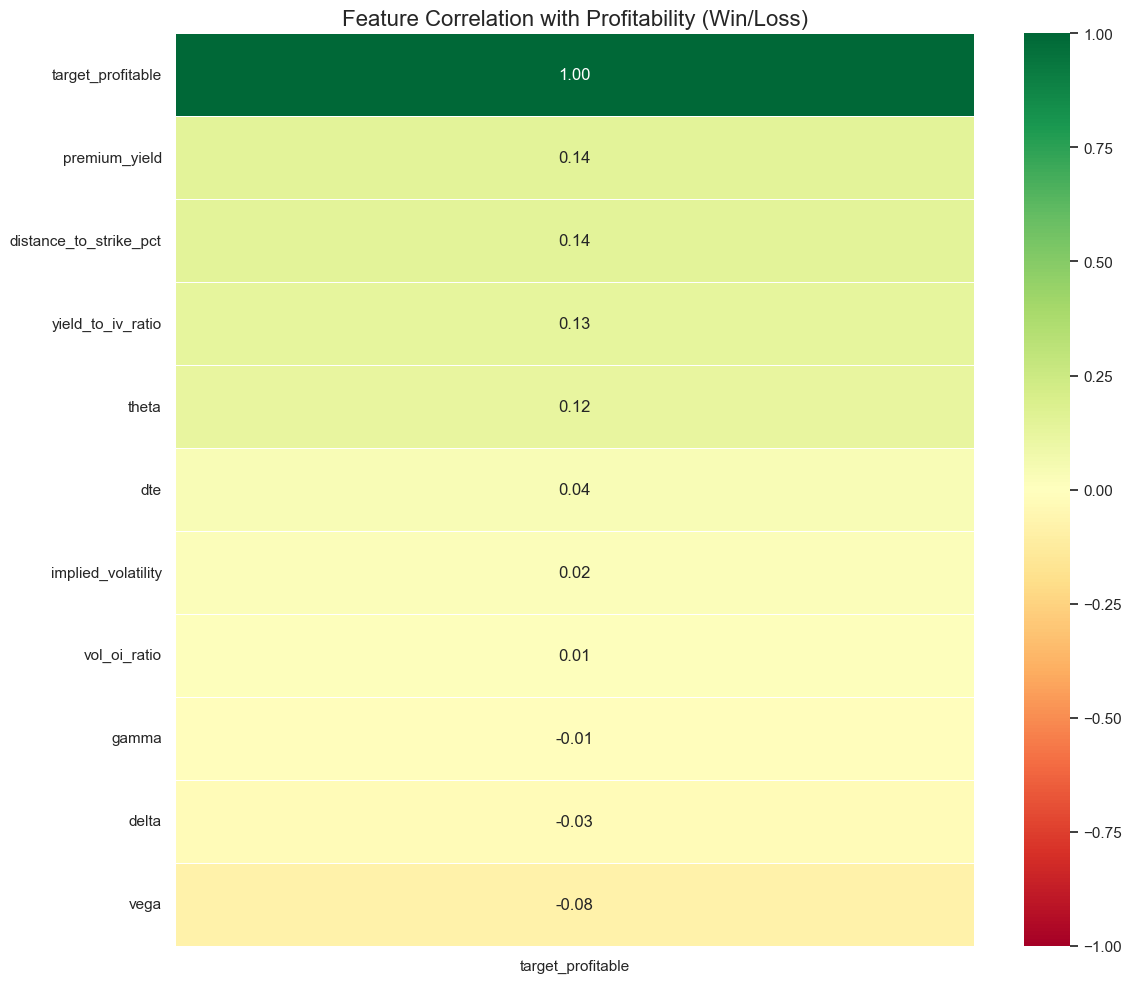

In [ ]:
analysis_cols = [
    'delta', 'gamma', 'theta', 'vega', 'implied_volatility', 
    'distance_to_strike_pct', 'premium_yield', 'vol_oi_ratio', 
    'dte', 'yield_to_iv_ratio', 'target_profitable'
]

corr_matrix = df_ml[analysis_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix[['target_profitable']].sort_values(by='target_profitable', ascending=False), 
    annot=True, 
    cmap='RdYlGn', # Red (Negative) to Green (Positive)
    vmin=-1, 
    vmax=1,
    fmt=".2f",
    linewidths=.5
)
plt.title("Feature Correlation with Profitability (Win/Loss)", fontsize=16)
plt.tight_layout()
plt.show()

/var/folders/r7/csk_79fx1pb0nd8bby20017c0000gn/T/ipykernel_55209/2969634369.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/r7/csk_79fx1pb0nd8bby20017c0000gn/T/ipykernel_55209/2969634369.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(['Loss (False)', 'Win (True)'])
/var/folders/r7/csk_79fx1pb0nd8bby20017c0000gn/T/ipykernel_55209/2969634369.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/r7/csk_79fx1pb0nd8bby20017c0000gn/T/ipykernel_55209/2969634369.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. af

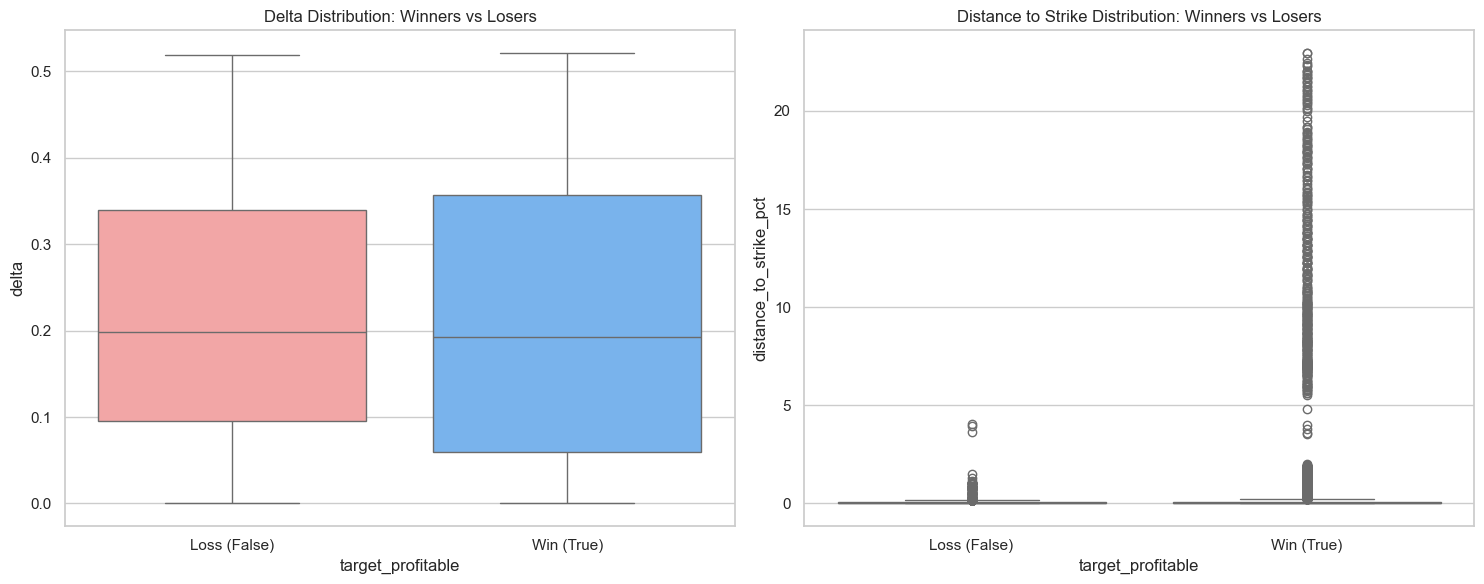

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Delta vs Profitability
sns.boxplot(
    data=df_ml, 
    x='target_profitable', 
    y='delta', 
    ax=axes[0],
    palette=['#ff9999', '#66b3ff']
)
axes[0].set_title("Delta Distribution: Winners vs Losers")
axes[0].set_xticklabels(['Loss (False)', 'Win (True)'])

# Plot 2: Distance to Strike vs Profitability
sns.boxplot(
    data=df_ml, 
    x='target_profitable', 
    y='distance_to_strike_pct', 
    ax=axes[1],
    palette=['#ff9999', '#66b3ff']
)
axes[1].set_title("Distance to Strike Distribution: Winners vs Losers")
axes[1].set_xticklabels(['Loss (False)', 'Win (True)'])

plt.tight_layout()
plt.show()